# I am basically going to excercise a bit and try different codes


In [1]:
# The libraries as always
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from scipy.stats import norm

## 1. Defining the stochastic process

In [2]:
# Models the underling asset assuming geometetric brownian motion
class StochasticProcess:

    # Probability of motion in a certain direction
    def motion_probability(self, motion_to):
        if motion_to > self.current_asset_price:
            pass
        elif motion_to <= self.current_asset_price:
            pass

    def time_step(self):
        # Brownian motion is ~N(0, delta_t), np.random.normal takes mean and standard deviation
        dW = np.random.normal(0, math.sqrt(self.delta_t)) 
        dS = self.drift*self.current_asset_price*self.delta_t + self.asset_volatility*self.current_asset_price*dW
        self.asset_prices.append(self.current_asset_price + dS)
        # Reassign the new current asset price for next time step
        self.current_asset_price = self.current_asset_price + dS

    def __init__(self, asset_price, drift, delta_t, asset_volatility):
        self.current_asset_price = asset_price
        self.asset_prices = []
        self.asset_prices.append(asset_price)
        self.drift = drift
        self.delta_t = delta_t
        self.asset_volatility = asset_volatility

## Understanding brownian motions.

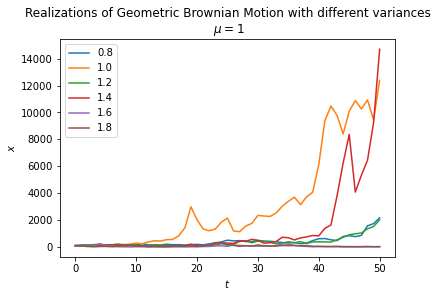

In [3]:
mu = 1
n = 50
dt = 0.1
x0 = 100
np.random.seed(1)

sigma = np.arange(0.8, 2, 0.2)

x = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(len(sigma), n)).T
)
x = np.vstack([np.ones(len(sigma)), x])
x = x0 * x.cumprod(axis=0)

plt.plot(x)
plt.legend(np.round(sigma, 2))
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title(
    "Realizations of Geometric Brownian Motion with different variances\n $\mu=1$"
)
plt.show()

## 2. Testing it on the simplest of options.
Example taken from: https://medium.com/swlh/python-for-pricing-exotics-3a2bfab5ff66

In [4]:
class EuroCall:

    def __init__(self, strike):
        self.strike = strike

In [5]:
class EuroCallSimulation:

    def __init__(self, EuroCall, n_options, initial_asset_price, drift, delta_t, asset_volatility, time_to_expiration, risk_free_rate):
        # List of stochastic processes modeling the underlying asset
        stochastic_processes = []
        # Generate a stochastic process for each option
        for i in range(n_options):
            stochastic_processes.append(StochasticProcess(initial_asset_price, drift, delta_t, asset_volatility)) # Note delta t is annualized

        # Automatically create the required steps in time for the simulation by creating a time_step in the stochastic process if its still greator than 0
        # Make n_time_steps for each stochastic process
        for stochastic_process in stochastic_processes:
            tte = time_to_expiration
            while((tte-stochastic_process.delta_t) > 0):
                # Account for the passing of time
                tte = tte - stochastic_process.delta_t
                # Take a time step in the stochastic process
                stochastic_process.time_step()

        payoffs = []
        # for each stochastic process determine the payoff (if there is one)
        for stochastic_process in stochastic_processes:
            payoff = stochastic_process.asset_prices[len(stochastic_process.asset_prices)-1] - EuroCall.strike
            z = payoff if payoff > 0 else 0
            payoffs.append(z)
        self.price = np.average(payoffs)*math.exp(-time_to_expiration*risk_free_rate)

## 2.1.1 Wherefrom the parameters for the simulation are:
EuroCall(296): European call with a 296 strike price.

10000: Number of sample paths to generate.

295: Current underlying asset price.

1/365: Time step between asset prices.

.2435 (24.35%): Implied volatility.

39/365: Time until expiration.

.0017: 1 year U.S. Treasury rate (risk free rate).


## 2.1.2 Checking results

In [6]:
print('Monte Carlo Euro Call Price: ', EuroCallSimulation(EuroCall(296), 10000, 295, 0, 1/365, .2435, 39/365, .0017).price)

Monte Carlo Euro Call Price:  8.9777267273707


## 2.2 The model for European Calls pricing.

In [7]:
class EuropeanCall:

    def call_delta(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        return z1

    def call_gamma(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z2 = z1/(asset_price*asset_volatility*math.sqrt(time_to_expiration))
        return z2

    def call_vega(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z2 = asset_price*z1*math.sqrt(time_to_expiration)
        return z2

    def call_price(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        b = math.exp(-risk_free_rate*time_to_expiration)
        x1 = math.log(asset_price/(b*strike_price)) + .5*(asset_volatility*asset_volatility)*time_to_expiration
        x1 = x1/(asset_volatility*(time_to_expiration**.5))
        z1 = norm.cdf(x1)
        z1 = z1*asset_price
        x2 = math.log(asset_price/(b*strike_price)) - .5*(asset_volatility*asset_volatility)*time_to_expiration
        x2 = x2/(asset_volatility*(time_to_expiration**.5))
        z2 = norm.cdf(x2)
        z2 = b*strike_price*z2
        return z1 - z2

    def __init__(
        self, asset_price, asset_volatility, strike_price,
        time_to_expiration, risk_free_rate
            ):
        self.asset_price = asset_price
        self.asset_volatility = asset_volatility
        self.strike_price = strike_price
        self.time_to_expiration = time_to_expiration
        self.risk_free_rate = risk_free_rate
        self.price = self.call_price(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.delta = self.call_delta(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.gamma = self.call_gamma(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)
        self.vega = self.call_vega(asset_price, asset_volatility, strike_price, time_to_expiration, risk_free_rate)

In [10]:
print('Black-Scholes European Call price: ', EuropeanCall(295, .2435, 296, 39/365, .0017).price)
print('Monte Carlo Euro Call Price: ', EuroCallSimulation(EuroCall(296), 100000, 295, 0, 1/365, .2435, 39/365, .0017).price)

Black-Scholes European Call price:  8.914368847065361
Monte Carlo Euro Call Price:  8.732824856036322


# 3. Another example taken from: 
https://www.codearmo.com/blog/pricing-options-monte-carlo-simulation-python

## Showing geometrical brownian motion paths:

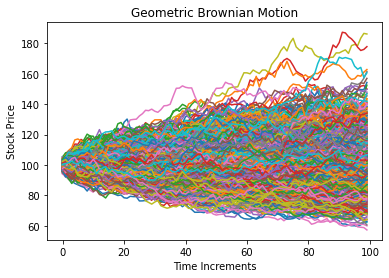

In [22]:
# To understand the formula check the link above, it's pratically at the beginning.
def geo_paths(S, T, r, q, sigma, steps, N):
    """
    Inputs
    #S = Current stock Price
    #K = Strike Price
    #T = Time to maturity 1 year = 1, 1 months = 1/12
    #r = risk free interest rate
    #q = dividend yield
    # sigma = volatility 
    
    Output
    # [steps,N] Matrix of asset paths 
    """
    dt = T/steps
    #S_{T} = ln(S_{0})+\int_{0}^T(\mu-\frac{\sigma^2}{2})dt+\int_{0}^T \sigma dW(t)
    ST = np.log(S) +  np.cumsum(((r - q - sigma**2/2)*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=(steps,N))),axis=0)
    
    return np.exp(ST)

S = 100 #stock price S_{0}
K = 110 # strike
T = 1/2 # time to maturity
r = 0.05 # risk free risk in annual %
q = 0.02 # annual dividend rate
sigma = 0.25 # annual volatility in %
steps = 100 # time steps
N = 1000 # number of trials

paths= geo_paths(S,T,r, q,sigma,steps,N)

plt.plot(paths);
plt.xlabel("Time Increments")
plt.ylabel("Stock Price")
plt.title("Geometric Brownian Motion");

## The B&S formula for a call option is the following:

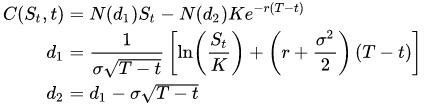

## For Put options

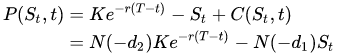

### Writing it in python

In [17]:
def black_scholes_call(S,K,T,r,q,sigma):
    """
    Inputs
    #S = Current stock Price
    #K = Strike Price
    #T = Time to maturity 1 year = 1, 1 months = 1/12
    #r = risk free interest rate
    #q = dividend yield
    # sigma = volatility 
    
    Output
    # call_price = value of the option 
    """
    d1 = (np.log(S/K) + (r - q + sigma**2/2)*T) / sigma*np.sqrt(T)
    d2 = d1 - sigma* np.sqrt(T)
    
    call = S * np.exp(-q*T)* norm.cdf(d1) - K * np.exp(-r*T)*norm.cdf(d2)
    return call

### Comparing it with the simulation

In [18]:
payoffs = np.maximum(paths[-1]-K, 0) # Computing payoffs 
option_price = np.mean(payoffs)*np.exp(-r*T) #discounting back to present value

bs_price = black_scholes_call(S,K,T,r,q,sigma)

print(f"Black Scholes Price is {bs_price}")
print(f"Simulated price is {option_price}")

Black Scholes Price is 3.7451887662410783
Simulated price is 4.125586188705578


### Improving precision with N=100000 paths

In [19]:
N=100000
paths= geo_paths(S, T, r, q,sigma, steps, N)
payoffs = np.maximum(paths[-1]-K, 0) # Getting from all paths the payoffs and placing 0 if negative.
option_price = np.exp(-r*T)*np.mean(payoffs) # Discounting

bs_price = black_scholes_call(S,K,T,r,q,sigma)

print(f"Black Scholes Price is {bs_price}")
print(f"Simulated price is {option_price}")

Black Scholes Price is 3.7451887662410783
Simulated price is 3.8698761556325207


This happens because as we increase N towards infinity the price approaches the Black-Scholes price, due to  Central Limit Theorem. I will show now a visual rappresentation of what happens above where the montecarlo algorithm considers only the green values in the plot.


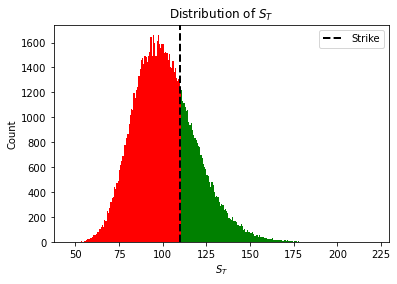

In [21]:
n, bins, patches = plt.hist(paths[-1],bins=250);
for c, p in zip(bins, patches):
    if c > K:
        plt.setp(p, 'facecolor', 'green')
    else:
        plt.setp(p, 'facecolor', 'red')

plt.axvline(K, color='black', linestyle='dashed', linewidth=2,label="Strike")
plt.title("Distribution of $S_{T}$")
plt.xlabel("$S_{T}$")
plt.ylabel('Count')
plt.legend();

In [42]:
np.shape(paths[-1])

(1000,)